<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Notebook_help_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence Classification with Huggingface-Trainer

Creators: Luca Moroni

Official Reference: https://huggingface.co/blog/sentiment-analysis-python

To face this notebook you must read and understand well the "NLP Notebook #5 - Transformers".

In this EXTRA notebook we will see the usage of Huggingface Trainer, a tested pipeline that led us to use less code and concentrate on other aspects than create the wheel again every times (e.g. training for loop, early stopping, ...).


Let's go through the code!

In [ ]:
!pip install accelerate -U
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
import torch
from datasets import load_dataset
from transformers import DataCollatorWithPadding

from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
)


### Model Parameters
# we will use with Distil-BERT
language_model_name = "distilbert-base-uncased"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In this example we will use **Sentiment Tree Bank corpus (SST2)**, one of the main benchmark for binary sentiment analysis task.

The dataset if freely available through Huggingface Datasets.

In [ ]:
# load our dataset
sst2_dataset = load_dataset("stanfordnlp/sst2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
## Let's see an example...
print(f"Sentence: {sst2_dataset['train']['sentence'][12]}")
print(f"Sentiment: {'Positive' if sst2_dataset['train']['label'][12] == 1 else 'Negative'}")

Sentence: the part where nothing 's happening , 
Sentiment: Negative


In [ ]:
## The structure of the huggingface dataset.
## Here the test set cannot be used since is a blind test set, so there aren't the gold labels.
sst2_dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

### Metric Definition

Looking only at cross entropy loss cannot allow us to understand effectivelly the real capabilities of our NLP model. So let's define a standard method to compute:

- **Accuracy** metric
- **F1** metric

In [ ]:
import evaluate

# Metrics

def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

## The Model

We will rely on the Huggingface **AutoModelForSequenceClassification** class from huggingface repository. This is a wrapper for encoder-only models, that allow us to simply create a model suitable to solve a classification task over textual sentences.

### BERT Encoding

We use a BERT-style pretrained encoder model, in this setting, we rely on the tokenization practices of those models.

Each sentence is:
- Splitted in tokens
- Added special tokens (\[CLS\], \[SEP\])
- Sum Position Embeddings
- Sum Segment Embeddings (Deprecated)

![alt text](https://miro.medium.com/v2/resize:fit:998/1*EKzyGf_l0e57XN491_YAyg.png)

### Sentence Classification

In the previous notebook you saw how to train a token level classifier to solve NER task, learning a MLP over each tokens of the input sentence. In the setting of sentence level classification the standard approaches apply a MLP over the [CLS] token's embedding of the last encoder layer. This is because the [CLS] token contains a lot of information about the **semantic and syntactitc** structure of the input sentence.

![alt text](https://jalammar.github.io/images/bert-classifier.png "Sentence Classification")

In [ ]:
## Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=2) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding=True, truncation=True)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

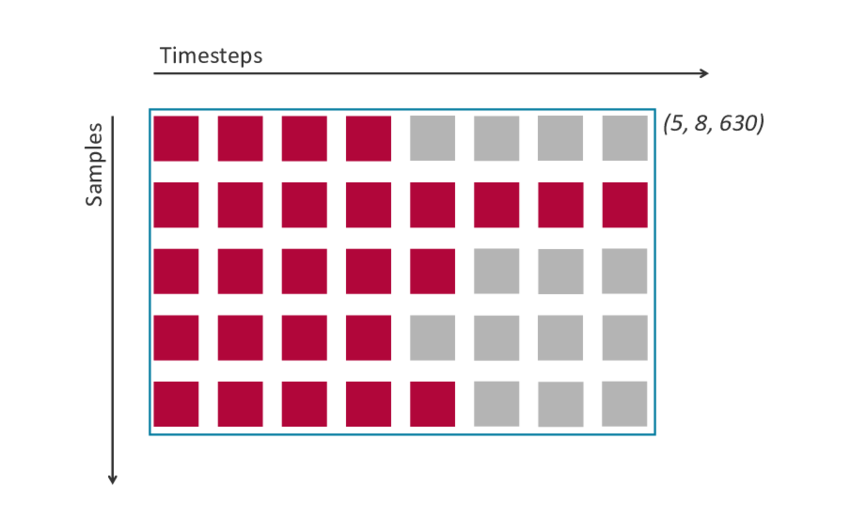

Here you can see a padded batch, The **GRAY** elements are added to have the same size for each sample.

**Data collators** are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

Link to huggingface documentation for the Data Collator functions (https://huggingface.co/docs/transformers/main_classes/data_collator)

In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets_sst2 = sst2_dataset.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

## Model Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_datasets_sst2["train"],
   eval_dataset=tokenized_datasets_sst2["validation"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-10-2e3b8ed3251c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss
500,0.369500
1000,0.242900
1500,0.200600
2000,0.172100


TrainOutput(global_step=2105, training_loss=0.24163020806754287, metrics={'train_runtime': 377.5739, 'train_samples_per_second': 178.373, 'train_steps_per_second': 5.575, 'total_flos': 1139506554896892.0, 'train_loss': 0.24163020806754287, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.23834238946437836,
 'eval_accuracy': 0.9208715596330275,
 'eval_f1': 0.9229050279329609,
 'eval_runtime': 4.505,
 'eval_samples_per_second': 193.562,
 'eval_steps_per_second': 24.195,
 'epoch': 1.0}

### Use the model to infere on unseen texts

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return "positive" if preds.item() == 1 else "negative"

In [ ]:
predict_sentiment("Today is a very beatifull day!!!!!!", model, tokenizer, "cuda:0")

'positive'

In [ ]:
predict_sentiment("Oh no, the milk was outdated", model, tokenizer, "cuda:0")

'negative'

In [ ]:
predict_sentiment("The coffee, due to the inflation, costs more than 1 euro", model, tokenizer, "cuda:0")

'negative'